In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# see more columns and rows
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [92]:
# read in data
arrests=pd.read_csv('pittsburgh_arrests_123119.csv')

# look at column types, missing values, identification numbers...
arrests.info()
print(arrests.isna().sum())

print('\nPK: '+str(arrests['PK'].unique().shape))
print('CCR: '+str(arrests['CCR'].unique().shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38158 entries, 0 to 38157
Data columns (total 16 columns):
PK                       38158 non-null int64
CCR                      38158 non-null int64
AGE                      37859 non-null float64
GENDER                   38158 non-null object
RACE                     38158 non-null object
ARRESTTIME               38158 non-null object
ARRESTLOCATION           38158 non-null object
OFFENSES                 38155 non-null object
INCIDENTLOCATION         38158 non-null object
INCIDENTNEIGHBORHOOD     36727 non-null object
INCIDENTZONE             38100 non-null object
INCIDENTTRACT            36749 non-null float64
COUNCIL_DISTRICT         33250 non-null float64
PUBLIC_WORKS_DIVISION    33250 non-null float64
X                        36810 non-null float64
Y                        36810 non-null float64
dtypes: float64(6), int64(2), object(8)
memory usage: 4.7+ MB
PK                          0
CCR                         0
AGE          

In [4]:
# remove nans in offenses
arrests = arrests[pd.notnull(arrests['OFFENSES'])]
#drop CCR value repeats
arrests=arrests.drop_duplicates(subset='CCR',keep='first')
# convert arrest times to datetime values and sort
arrests['ARRESTTIME'] = pd.to_datetime(arrests['ARRESTTIME'], yearfirst=True)
arrests= arrests.sort_values(by= ['ARRESTTIME']).reset_index(drop=True)


In [5]:
print('arrest totals per year')
for yr in np.arange(1998,2020,1):
    print(str(yr)+': '+str(len(arrests.loc[arrests['ARRESTTIME'].dt.year==yr])))

arrest totals per year
1998: 1
1999: 0
2000: 0
2001: 0
2002: 0
2003: 0
2004: 0
2005: 1
2006: 1
2007: 3
2008: 1
2009: 0
2010: 0
2011: 2
2012: 1
2013: 2
2014: 6
2015: 10
2016: 3564
2017: 9927
2018: 8890
2019: 8733


In [6]:
arrests=arrests.loc[arrests['ARRESTTIME']>= '2016-09'].reset_index(drop=True)
arrests=arrests.loc[arrests['ARRESTTIME']< '2020-01'].reset_index(drop=True)


In [7]:
# Police zone coordinates
# 1
# Latitude:	40.4569565
# Longitude:	-80.0160637
# 2
# Latitude:	40.4435808
# Longitude:	-79.9800111
# 3
# Latitude:	40.421685
# Longitude:	-79.9924763
# 4
# Latitude:	40.4414787
# Longitude:	-79.9212047
# 5
# Latitude:	40.4742729
# Longitude:	-79.9091618
# 6
# Latitude:	40.4420734
# Longitude:	-80.0322484


X_coord = {'Zone 1': -80.0160637 , 'Zone 2': -79.9800111, 'Zone 3': -79.9924763, 'Zone 4':-79.9212047 ,
           'Zone 5':-79.9091618 , 'Zone 6':-80.0322484 }

Y_coord = {'Zone 1': 40.4569565, 'Zone 2': 40.4435808 , 'Zone 3': 40.421685, 'Zone 4': 40.4414787 ,
           'Zone 5': 40.4742729, 'Zone 6':40.4420734 }
    
# map zone coordinates to all incident locations labeled with a zone description.
# if not 'zone', puts NaN                      
arrests["ZONEX"] = arrests['INCIDENTLOCATION'].map(X_coord)
arrests['ZONEY'] = arrests['INCIDENTLOCATION'].map(Y_coord)

# fills in x,y coordinates of zone incident locations
arrests['X']=arrests['X'].fillna(arrests['ZONEX'], axis=0)
arrests['Y']=arrests['Y'].fillna(arrests['ZONEY'], axis=0)
# remove ZONEX and ZONEY columns
arrests = arrests.drop(["ZONEX"], axis=1)
arrests = arrests.drop(["ZONEY"], axis=1)

In [8]:
# find total number of offenses per individual
arrests['NUMOFFENSES'] = arrests['OFFENSES'].apply(lambda x: len(x.split(' / ')))
# remove incidents that occur outside of Pittsburgh
arrests.loc[arrests['X'].isna()]['INCIDENTLOCATION'].unique()
arrests=arrests[arrests['INCIDENTLOCATION'] !='Zone OSC']
arrests=arrests[arrests['INCIDENTLOCATION'] !='Zone ']

In [9]:
# records the indivdiual charges pertaining to each felon 
df=[]
for index, row in arrests.iterrows():
    # each offense is separated by a ''/''.  Split on this.
    charges = row['OFFENSES'].split(' / ')
    for charge in charges:
        row['CHARGES']=charge
        df.append(row)
        row=row.drop('CHARGES',axis=0)
        
arrests_cleaned=pd.DataFrame(df).reset_index(drop=True)
# isinstance(arrests_cleaned, pd.DataFrame) # check if dataframe was made


True

In [10]:
# remove period
arrests_cleaned['CHARGES'] = arrests_cleaned['CHARGES'].str.replace('.','',regex=True) # remove period from string
# make column for arrest codes
arrests_cleaned['ARRESTCODE'] = arrests_cleaned['CHARGES'].apply(lambda x: x.split(" ",1)[0])
# make column for arrest descriptions
arrests_cleaned['ARRESTDESCRIPT'] = arrests_cleaned['CHARGES'].apply(lambda x: x.split(" ",1)[1])

# remove unwanted columns
arrests_cleaned = arrests_cleaned.drop(['CHARGES','OFFENSES'],axis=1)
# arrests_cleaned = arrests_cleaned.drop(['OFFENSES'],axis=1)

In [11]:
arrests_cleaned.index = arrests_cleaned['ARRESTTIME']
del arrests_cleaned.index.name
arrests_cleaned.head()

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,NUMOFFENSES,ARRESTCODE,ARRESTDESCRIPT
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,2706,Terroristic Threats
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,5104,Resisting Arrest or Other Law Enforcement
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,13(a)(31),Marijuana: Possession Small Amount
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,3802(a)(1),DUI - General Impairment
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,3802(c),DUI - Highest Rate of Alcohol - BAC >= 16%


In [12]:
arrests_cleaned.to_csv('arrests_cleaned.csv', index=False)

In [107]:
arrests_cleaned=pd.read_csv('arrests_cleaned.csv')
arrests_cleaned['ARRESTTIME'] = pd.to_datetime(arrests_cleaned['ARRESTTIME'], yearfirst=True)

arrests_cleaned.index = arrests_cleaned['ARRESTTIME']
# arrests_cleaned=arrests_cleaned.drop(['ARRESTTIME'],axis=1)
del arrests_cleaned.index.name
arrests_cleaned.head()

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,NUMOFFENSES,ARRESTCODE,ARRESTDESCRIPT
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,2706,Terroristic Threats
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,5104,Resisting Arrest or Other Law Enforcement
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,13(a)(31),Marijuana: Possession Small Amount
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,3802(a)(1),DUI - General Impairment
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,3802(c),DUI - Highest Rate of Alcohol - BAC >= 16%


In [108]:
charge_info=arrests_cleaned['ARRESTDESCRIPT'].value_counts()
charge_info=pd.DataFrame(charge_info).reset_index()
charge_info=charge_info.rename(columns={'index': 'crime', 'ARRESTDESCRIPT': 'count'})
charge_info['overall_pct']=(charge_info['count']/charge_info['count'].sum())*100
charge_info['cumsum']=charge_info['count'].cumsum()
charge_info['cumsum_pct']=charge_info['overall_pct'].cumsum()
# charge_info.head(20)

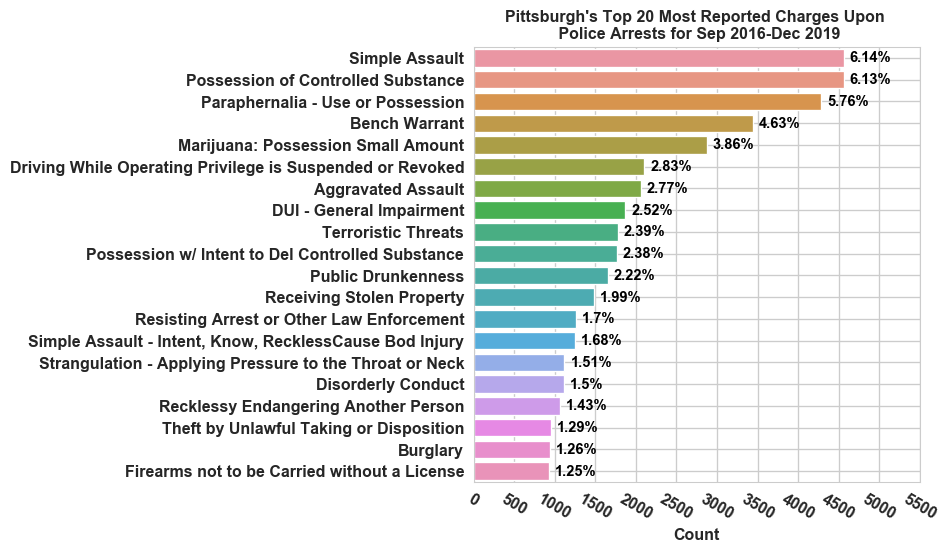

In [109]:
#barplot of top 20 most reported charges with arrests
fig = plt.figure(figsize=(6, 6), dpi=96)
barplt = fig.add_subplot(1, 1, 1)  # create an axes object in the figure

barplt = sns.barplot(y='crime', x='count', data=charge_info.loc[0:19])

fontsize=12
barplt.set_title("Pittsburgh's Top 20 Most Reported Charges Upon \n Police Arrests for Sep 2016-Dec 2019",
                 weight='bold',fontsize=fontsize)
barplt.set_ylabel('',fontweight='bold',fontsize=fontsize)
barplt.set_xlabel('Count',fontweight='bold',fontsize=fontsize)
    
barplt.set_xticks(np.arange(0,6000,500))

# fontsize=28
for tick in barplt.xaxis.get_ticklabels():
        tick.set(rotation=-30)
        tick.set_fontsize(fontsize)
        tick.set_fontweight('bold')
for tick in barplt.yaxis.get_ticklabels():
    tick.set_fontsize(fontsize)
    tick.set_fontweight('bold')
    
barplt.grid(linewidth=1)
# set bars in front of grid lines
barplt.set_axisbelow(True)
                 
# Add transparency to colors if need be
for patch in barplt.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

# add perecentages
j=0
for i in barplt.patches:
    barplt.text(i.get_width()+75, i.get_y()+.6, 
                str(round(charge_info['overall_pct'].iloc[j],2))+'%',
                fontsize=11, fontweight='bold', color='black')
    j=j+1

# plt.savefig('arrests_top_20_total_pct.png',bbox_inches='tight')
plt.show()

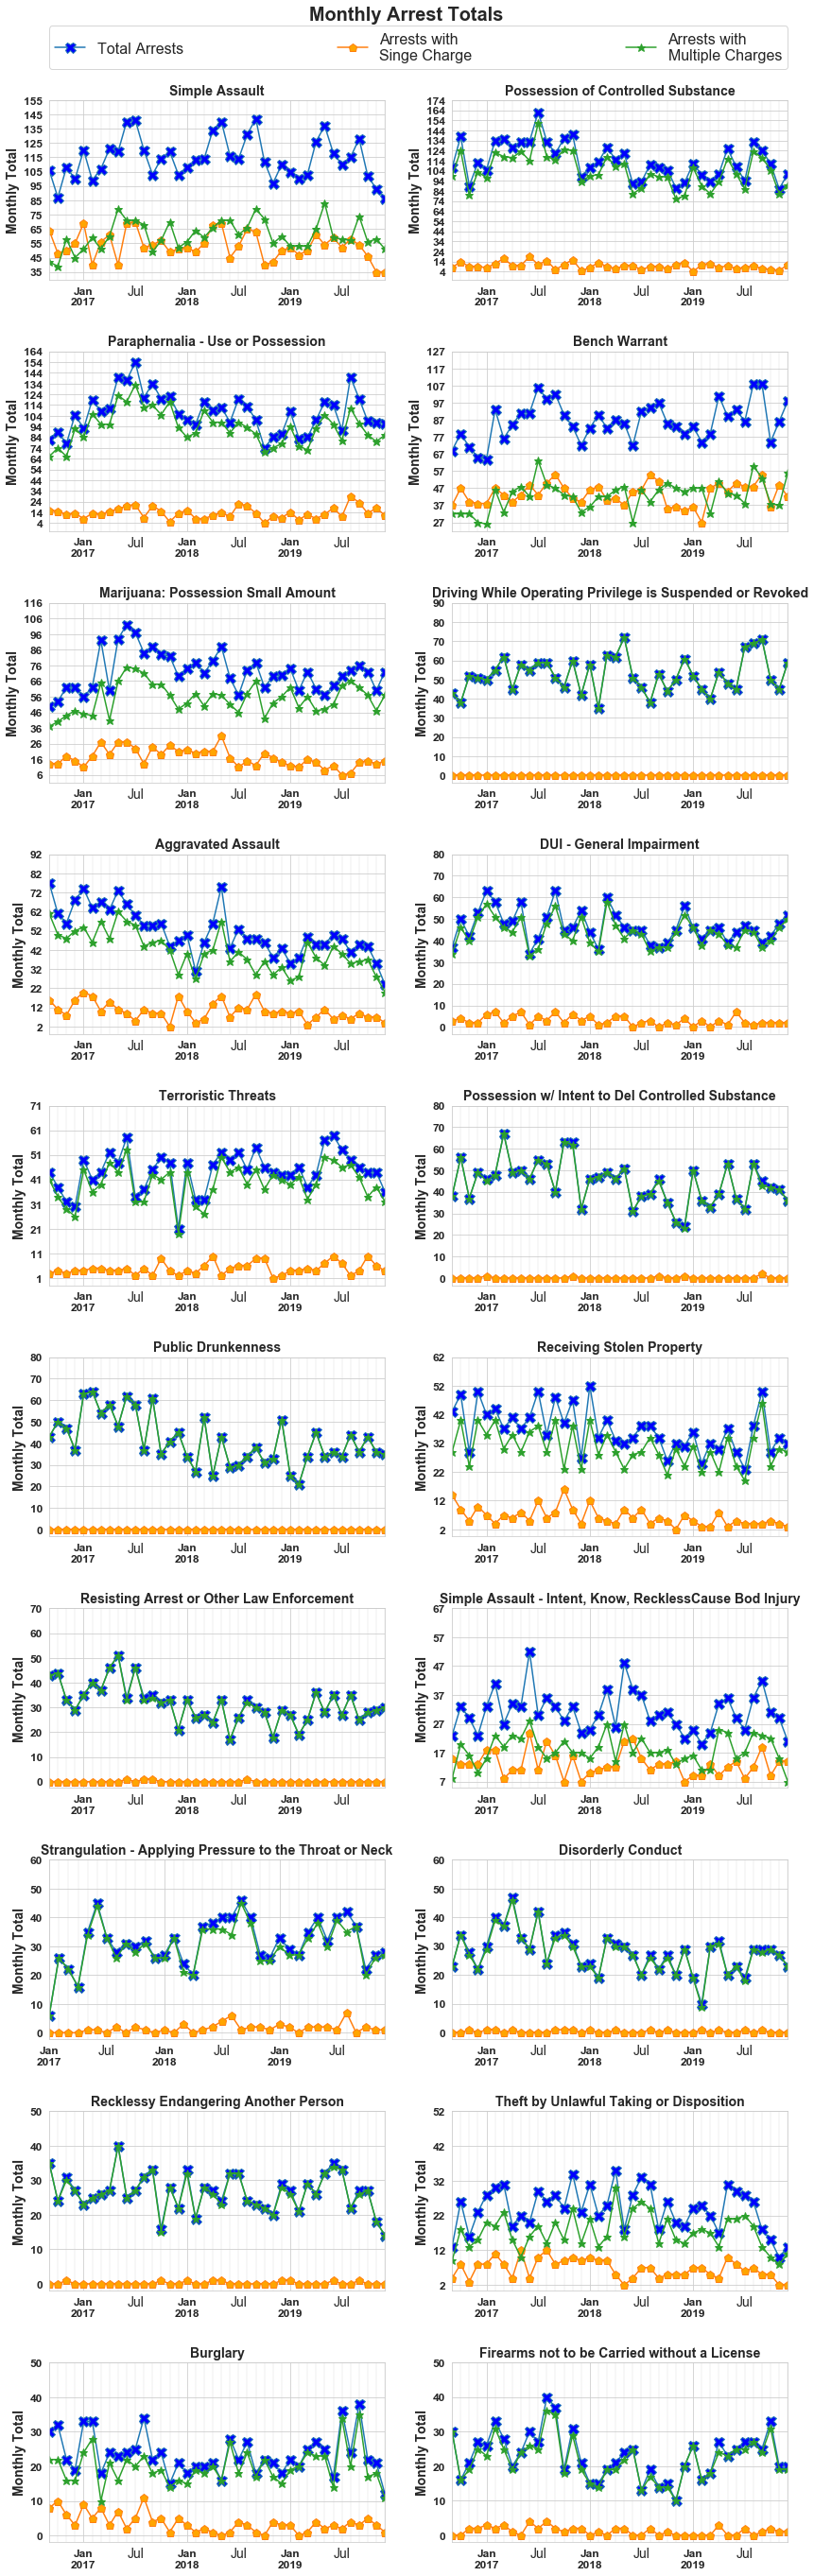

In [110]:
fig = plt.figure(figsize=(14,46))
sup_title=fig.suptitle('Monthly Arrest Totals',fontsize=20, fontweight='bold')

fontsize=14

for i,crime in enumerate(charge_info['crime'].iloc[0:20]):

    i=i+1
# find data to plot
    individ_crime = arrests_cleaned.loc[arrests_cleaned['ARRESTDESCRIPT']== crime]
    individ_month_arrests=individ_crime.resample('M').agg(dict(NUMOFFENSES='count'))
    individ_crime_single_total = individ_crime[individ_crime['NUMOFFENSES'] == 1]
    individ_month_arrests['SINGLECHARGES'] =individ_crime_single_total.resample('M').agg(dict(NUMOFFENSES='count'))
    individ_crime_multiple_total = individ_crime[individ_crime['NUMOFFENSES'] != 1]
    individ_month_arrests['MULTIPLECHARGES']=individ_crime_multiple_total.resample('M').agg(dict(NUMOFFENSES='count'))
    individ_month_arrests['DATE'] = individ_month_arrests.index
    individ_month_arrests=individ_month_arrests.fillna(0)
# plot data
    ax=fig.add_subplot(10,2,i)
    individ_month_arrests.plot(x='DATE',y='NUMOFFENSES',marker='X',markersize=11, markerfacecolor='blue',
                               ax=ax, label='Total Arrests',legend=False)
    individ_month_arrests.plot(x='DATE',y='SINGLECHARGES',marker='p',markersize=9, markerfacecolor='orange',
                               ax=ax, label='Arrests with \nSinge Charge', legend=False)
    individ_month_arrests.plot(x='DATE',y='MULTIPLECHARGES',marker='*',markersize=9,
                               ax=ax, label='Arrests with \nMultiple Charges', legend=False)
    
    ax.set_title(crime,fontsize=fontsize,fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Monthly Total',fontsize=fontsize,fontweight='bold')
    ax.set_yticks(np.arange(min(individ_month_arrests['SINGLECHARGES']), max(individ_month_arrests['NUMOFFENSES'])+20, 10))

    for tick in ax.xaxis.get_ticklabels():
        tick.set(rotation=0)
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
    
    ax.tick_params(axis='x', which='minor', labelsize=14)
    ax.grid(b=True,which='major', linewidth=.8)
    ax.grid(b=True,which='minor', linewidth=.3)
    # end points brought to front
    ax.axes.get_xaxis().set_visible(True)


fig.subplots_adjust(bottom=.1, hspace=0.4, wspace=0.2)
sup_title.set_y(0.91)
# global legend
bbox = (fig.subplotpars.left, fig.subplotpars.top+.01, fig.subplotpars.right-fig.subplotpars.left,.1)
ax.legend(bbox_to_anchor=bbox, mode='expand', loc='lower left', ncol=3, 
          borderaxespad=0., bbox_transform=fig.transFigure, fontsize=16)


# plt.savefig('top20month.png',bbox_inches='tight')
plt.show()

In [111]:
# aggregate monthly rates of specific crimes
crime_name=charge_info['crime'].iloc[4] # marijuana: small possession
crime_spec=arrests_cleaned.loc[arrests_cleaned['ARRESTDESCRIPT']== crime_name]
monarr=crime_spec.resample('M').agg(dict(ARRESTDESCRIPT='count'))
monarr['ARRESTTIME']=monarr.index
monarr.head()

,ARRESTDESCRIPT,ARRESTTIME
2016-09-30,50,2016-09-30
2016-10-31,53,2016-10-31
2016-11-30,62,2016-11-30
2016-12-31,62,2016-12-31
2017-01-31,56,2017-01-31


In [121]:
crime_merge = pd.merge(crime_spec,arrests_cleaned[['PK','ARRESTDESCRIPT']], on='PK', how='inner')
crime_merge=crime_merge.set_index('ARRESTTIME',drop=False)
crime_merge = crime_merge[crime_merge['ARRESTDESCRIPT_y'] != crime_name]
crime_merge = crime_merge.drop_duplicates(subset='CCR',keep='first')
del crime_merge.index.name
crime_merge.head()

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,NUMOFFENSES,ARRESTCODE,ARRESTDESCRIPT_x,ARRESTDESCRIPT_y
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,13(a)(31),Marijuana: Possession Small Amount,Terroristic Threats
2016-09-01 15:10:00,1975570,16164729,25.0,M,B,2016-09-01 15:10:00,"40th ST & Foster ST Pittsburgh, PA 15201","40th ST & Foster ST Pittsburgh, PA 15201",Central Lawrenceville,2,901.0,7.0,2.0,-79.963474,40.470031,4,13(a)(31),Marijuana: Possession Small Amount,Driving While Operating Privilege is Suspended...
2016-09-01 22:30:00,1975630,16165033,38.0,M,B,2016-09-01 22:30:00,"900 Block Freeport RD Pittsburgh, PA 15215","900 Block Freeport RD Pittsburgh, PA 15215",Lincoln-Lemington-Belmar,5,1201.0,9.0,2.0,-79.894317,40.488082,5,13(a)(31),Marijuana: Possession Small Amount,Possession of Controlled Substance
2016-09-01 23:22:00,1975511,16165050,16.0,M,B,2016-09-01 23:22:00,"7300 Block Frankstown AV Pittsburgh, PA 15208","7300 Block Frankstown AV Pittsburgh, PA 15208",Homewood North,5,1302.0,9.0,2.0,-79.894058,40.456938,4,13(a)(31),Marijuana: Possession Small Amount,Firearms not to be Carried without a License
2016-09-02 13:51:00,1975626,16165414,17.0,M,B,2016-09-02 13:51:00,"30 Block E Carson ST Pittsburgh, PA 15219","200 Block Lelia ST Pittsburgh, PA 15211",Mount Washington,3,1915.0,2.0,5.0,-80.010300,40.421822,5,13(a)(31),Marijuana: Possession Small Amount,Criminal Conspiracy


In [122]:

mj_many=crime_merge.resample('M').agg(dict(ARRESTDESCRIPT_x='count'))
mj_many['ARRESTTIME']=mj_many.index
mj_many['single_charge']=monarr['ARRESTDESCRIPT']-mj_many['ARRESTDESCRIPT_x']
mj_many.rename(columns = {'ARRESTDESCRIPT_x':'multiple_charges'}, inplace = True) 
mj_many.head()


,multiple_charges,ARRESTTIME,single_charge
2016-09-30,37,2016-09-30,13
2016-10-31,40,2016-10-31,13
2016-11-30,44,2016-11-30,18
2016-12-31,47,2016-12-31,15
2017-01-31,45,2017-01-31,11


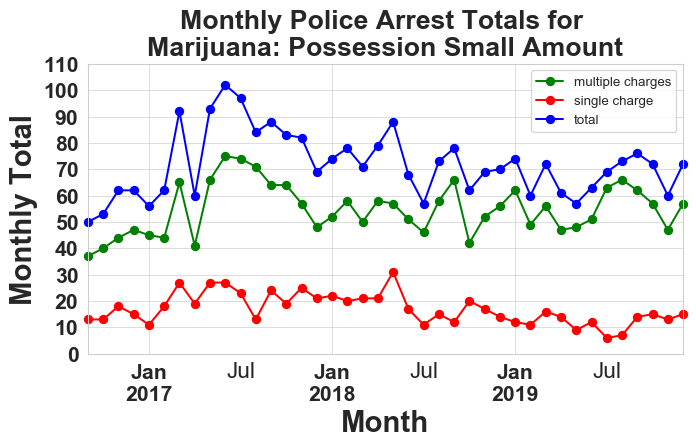

'Marijuana: Possession Small Amount'

In [123]:
plt.figure(figsize=(8,4), dpi=96)
ax = plt.gca()
ax1=mj_many['multiple_charges'].plot(label='multiple charges', marker='o',color='g', clip_on = False)
ax2=mj_many['single_charge'].plot(label='single charge', marker='o',color='r', clip_on = False)
ax3= monarr['ARRESTDESCRIPT'].plot(label='total', marker='o',color='b', clip_on = False)

ax1.legend(loc=1)
ax2.legend(loc=1)
ax3.legend(loc=1)

ax.set_xlabel('Month',fontsize=22,fontweight='bold')
ax.set_ylabel('Monthly Total',fontsize=22,fontweight='bold')
ax.set_title('Monthly Police Arrest Totals for \n'+crime_name,fontsize=20, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='x', which='minor', labelsize=17)
for tick in ax.xaxis.get_ticklabels():
        tick.set(rotation=0)
        tick.set_fontweight('bold')
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontweight('bold')
ax.grid(linewidth=.5)
ax.set_yticks(np.arange(0,120,10))

plt.show()
# plt.savefig('arrests_specific.png',bbox_inches='tight',dpi=200)
crime_name

<function matplotlib.pyplot.show(*args, **kw)>

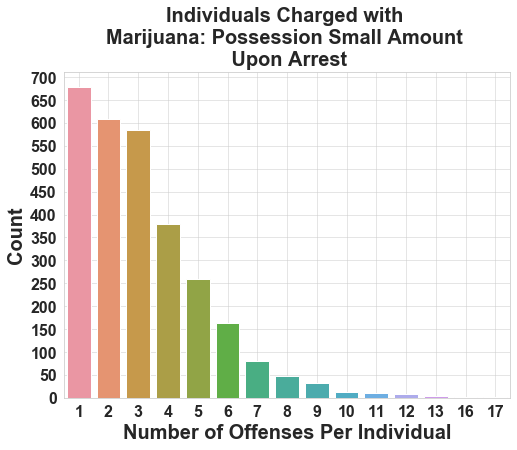

In [124]:
plt.close()
plt.figure(figsize=(8,6))

mj= sns.countplot(x="NUMOFFENSES", data=arrests_cleaned.loc[arrests_cleaned['ARRESTDESCRIPT']==crime_name])
mj.set_xlabel('Number of Offenses Per Individual',fontsize=20,fontweight='bold')
mj.set_ylabel('Count',fontsize=20,fontweight='bold')
mj.set_title('Individuals Charged with \n'+crime_name+' \n Upon Arrest',fontsize=20, fontweight='bold')
mj.tick_params(axis='both', which='major', labelsize=16)
mj.tick_params(axis='x', which='minor', labelsize=17)
for tick in mj.xaxis.get_ticklabels():
        tick.set(rotation=0)
        tick.set_fontweight('bold')
for tick in mj.yaxis.get_ticklabels():
    tick.set_fontweight('bold')
mj.grid(linewidth=.5)
mj.set_axisbelow(True)
mj.set_yticks(np.arange(0,750,50))

# mjh.set_xlabel('aka',fontsize=12)
# plt.savefig('arrestsmjbarg.png',bbox_inches='tight')
plt.show

In [128]:
import warnings
warnings.filterwarnings('ignore')
upto_june2018=mj_many.loc['2017-01':'2018-06']
upto_june2018['ID']='up to june 2018'
after_june2018=mj_many.loc['2018-07':]
after_june2018['ID'] = 'after june 2018'
labeled=pd.concat([upto_june2018,after_june2018])
labeled.head()


,multiple_charges,ARRESTTIME,single_charge,ID
2017-01-31,45,2017-01-31,11,up to june 2018
2017-02-28,44,2017-02-28,18,up to june 2018
2017-03-31,65,2017-03-31,27,up to june 2018
2017-04-30,41,2017-04-30,19,up to june 2018
2017-05-31,66,2017-05-31,27,up to june 2018


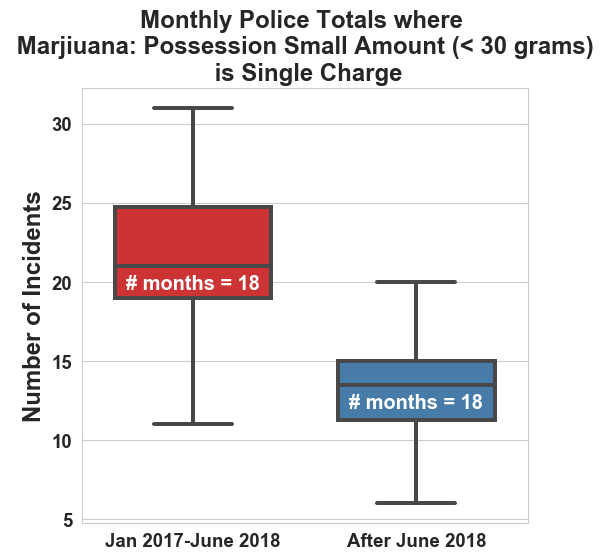

In [130]:
plt.figure(figsize=(6,6), dpi=96)
sns.set_style("whitegrid")
boxplt = sns.boxplot(x='ID',y='single_charge',
                     data=labeled,
                     palette='Set1',
                     width=0.7,
                     linewidth=3,
                     fliersize=0,
                     whis=1.5)

fontsize=18
boxplt.set_title('Monthly Police Totals where \n Marjiuana: Possession Small Amount (< 30 grams) \n is Single Charge',fontsize=18, fontweight='bold')
boxplt.set_ylabel('Number of Incidents',fontweight='bold',fontsize=fontsize)
boxplt.set_xlabel('',fontweight='bold',fontsize=fontsize)
    
# barplt.set_xticks(np.arange(0,8,1))

fontsize=14
for tick in boxplt.xaxis.get_ticklabels():
        tick.set(rotation=0)
        tick.set_fontsize(fontsize)
        tick.set_fontweight('bold')
for tick in boxplt.yaxis.get_ticklabels():
    tick.set_fontsize(fontsize)
    tick.set_fontweight('bold')
    
    # Add transparency to colors
for patch in boxplt.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))
    
    
# Calculate number of obs per group & median to position labels
medians = labeled.groupby(['ID'])['single_charge'].median().values
nobs = labeled.groupby("ID").size().values
plt.text(0,medians[1]-1.5, '# months = ' + str(nobs[1]), horizontalalignment='center', color='w', fontsize=15, fontweight='bold')
plt.text(1,medians[0]-1.5, '# months = ' + str(nobs[0]), horizontalalignment='center', color='w', fontsize=15, fontweight='bold')

xtic=['Jan 2017-June 2018', 'After June 2018']
boxplt.set_xticklabels(xtic)
# plt.savefig('boxplt2017.png',bbox_inches='tight')


plt.show()

In [148]:
print(upto_june2018['single_charge'].describe())
print('')
print(after_june2018['single_charge'].describe())

count    18.000000
mean     21.444444
std       5.043601
min      11.000000
25%      19.000000
50%      21.000000
75%      24.750000
max      31.000000
Name: single_charge, dtype: float64

count    18.000000
mean     12.944444
std       3.438061
min       6.000000
25%      11.250000
50%      13.500000
75%      15.000000
max      20.000000
Name: single_charge, dtype: float64


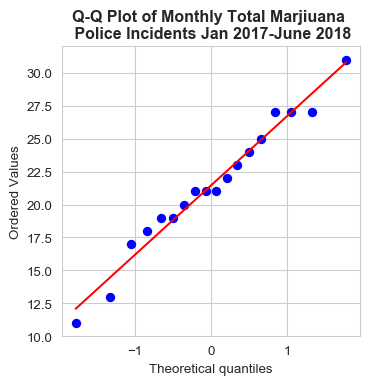

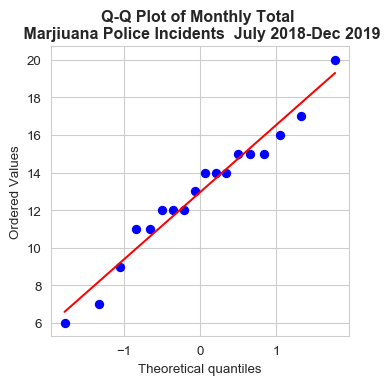

In [133]:
import scipy
fig= plt.figure(figsize=(4,4), dpi=96)
b4 = scipy.stats.probplot(upto_feb2017['single_charge'], plot= plt)
plt.title('Q-Q Plot of Monthly Total Marjiuana \n Police Incidents Jan 2017-June 2018', fontweight='bold')
# plt.savefig('b4feb2017.png',bbox_inches='tight')
plt.show()

fig= plt.figure(figsize=(4,4), dpi=96)
aft = scipy.stats.probplot(after_feb2017['single_charge'], plot= plt)
plt.title('Q-Q Plot of Monthly Total \n Marjiuana Police Incidents  July 2018-Dec 2019', fontweight='bold')
# plt.savefig('afterfeb2017.png',bbox_inches='tight')
plt.show()

In [ ]:
print(scipy.stats.shapiro(upto_june2018['single_charge']))
print('')
print(scipy.stats.shapiro(after_june2018['single_charge']))
print('')
print(scipy.stats.levene(upto_june2018['single_charge'], after_june2018['single_charge']))

In [152]:
# have unequal sample size and variance, use Welch's t test
scipy.stats.ttest_ind(upto_june2018['single_charge'], after_june2018['single_charge'], equal_var = True)

(0.9769303202629089, 0.9129541516304016)

(0.9709314703941345, 0.8150143623352051)

LeveneResult(statistic=1.5843195266272185, pvalue=0.21671395029031792)


Ttest_indResult(statistic=5.908053490296667, pvalue=1.1336400906252983e-06)

reject null-hypothesis.  mean not the same. suggest alternative what happened?

In [34]:
individ_crime = arrests_cleaned[arrests_cleaned['ARRESTCODE'].str.contains('2701')]#== crime1) | (arrests_cleaned['ARRESTDESCRIPT']== crime2)]
individ_crime = individ_crime[~individ_crime['INCIDENTLOCATION'].str.contains('Zone')]
# individ_crime.shape

(6186, 18)

In [4]:
import warnings
warnings.filterwarnings('ignore')
crime1 = charge_info['crime'].iloc[0]
crime2 = charge_info['crime'].iloc[13]

individ_crime = arrests_cleaned[arrests_cleaned['ARRESTCODE'].str.contains('2701')]#== crime1) | (arrests_cleaned['ARRESTDESCRIPT']== crime2)]
individ_crime = individ_crime[~individ_crime['INCIDENTLOCATION'].str.contains('Zone')]
# individ_crime.shape
individ_crime['YEAR']=individ_crime['ARRESTTIME'].dt.year
individ_crime['MONTH']=individ_crime['ARRESTTIME'].dt.month
individ_crime['DAY']=individ_crime['ARRESTTIME'].dt.day
individ_crime['HOUR']=individ_crime['ARRESTTIME'].dt.hour
individ_crime['MINUTE']=individ_crime['ARRESTTIME'].dt.minute
# 
print(individ_crime.shape)

individ_crime = individ_crime[pd.notnull(individ_crime['INCIDENTNEIGHBORHOOD'])]
individ_crime = individ_crime[pd.notnull(individ_crime['AGE'])]

print(individ_crime.shape)

individ_crime = individ_crime[~individ_crime['INCIDENTLOCATION'].str.contains('Zone')]
print(individ_crime.shape)

individ_crime[individ_crime['X']==0]
individ_crime.isna().sum()
print(individ_crime['INCIDENTNEIGHBORHOOD'].value_counts())

individ_crime_single = individ_crime[individ_crime['NUMOFFENSES'] == 1]
individ_crime_multiple = individ_crime[individ_crime['NUMOFFENSES'] != 1]

individ_month_arrests=individ_crime.resample('M').agg(dict(NUMOFFENSES='count'))
individ_month_arrests['SINGLECHARGES'] =individ_crime_single.resample('M').agg(dict(NUMOFFENSES='count'))
individ_month_arrests['MULTIPLECHARGES'] =individ_crime_multiple.resample('M').agg(dict(NUMOFFENSES='count'))
individ_month_arrests['TIME']=individ_month_arrests.index
individ_month_arrests
# individ_crime['ARRESTDESCRIPT'].value_counts()

(6186, 23)
(6132, 23)
(6132, 23)
Carrick                        263
South Side Flats               246
Central Business District      243
Marshall-Shadeland             204
East Hills                     195
Homewood North                 195
Mount Washington               182
Knoxville                      179
Brookline                      174
Beechview                      160
Homewood South                 159
Sheraden                       157
Hazelwood                      139
Brighton Heights               132
East Liberty                   132
Northview Heights              127
Perry South                    126
Spring Hill-City View          115
Lincoln-Lemington-Belmar       112
Bedford Dwellings              109
Allentown                      104
Perry North                     96
Crafton Heights                 94
Middle Hill                     91
Elliott                         88
East Allegheny                  87
Garfield                        83
Bloomfield            

,NUMOFFENSES,SINGLECHARGES,MULTIPLECHARGES,TIME
2016-09-30,144,80,64,2016-09-30
2016-10-31,132,63,69,2016-10-31
2016-11-30,146,64,82,2016-11-30
2016-12-31,132,67,65,2016-12-31
2017-01-31,171,90,81,2017-01-31
2017-02-28,146,60,86,2017-02-28
2017-03-31,150,65,85,2017-03-31
2017-04-30,171,74,97,2017-04-30
2017-05-31,166,56,110,2017-05-31
2017-06-30,207,96,111,2017-06-30


In [7]:
individ_crime.head()

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,NUMOFFENSES,ARRESTCODE,ARRESTDESCRIPT,YEAR,MONTH,DAY,HOUR,MINUTE
2016-09-01 10:45:00,1975132,16159776,32.0,F,B,2016-09-01 10:45:00,"600 Block 1st AV Pittsburgh, PA 15219","1300 Block Woodland AV Pittsburgh, PA 15212",Marshall-Shadeland,1,2715.0,1.0,1.0,-80.030266,40.469223,2,2701(a)(3),Simple Assault - Attempts by Physical Menace,2016,9,1,10,45
2016-09-01 10:48:00,1975306,16160487,22.0,M,H,2016-09-01 10:48:00,"900 Block Woodlow ST Pittsburgh, PA 15205","900 Block Woodlow ST Pittsburgh, PA 15205",Crafton Heights,6,2814.0,2.0,5.0,-80.052204,40.445900,1,2701,Simple Assault,2016,9,1,10,48
2016-09-01 16:00:00,1975034,16033848,23.0,F,B,2016-09-01 16:00:00,"900 Block 2nd AV Pittsburgh, PA 15219","1100 Block Buente ST Pittsburgh, PA 15212",Spring Hill-City View,1,2620.0,1.0,1.0,-79.995545,40.466617,2,2701,Simple Assault,2016,9,1,16,0
2016-09-01 17:29:00,1975577,16164831,24.0,M,B,2016-09-01 17:29:00,"1700 Block Belleau DR Pittsburgh, PA 15212","1700 Block Belleau DR Pittsburgh, PA 15212",Fineview,1,2509.0,6.0,1.0,-80.006980,40.460303,2,2701,Simple Assault,2016,9,1,17,29
2016-09-01 18:44:00,1975086,16152627,52.0,M,W,2016-09-01 18:44:00,"60 Block Luella ST Pittsburgh, PA 15212","East Ohio ST & Middle ST Pittsburgh, PA 15212",East Allegheny,1,2304.0,1.0,1.0,-79.999159,40.453752,1,2701,Simple Assault,2016,9,1,18,44


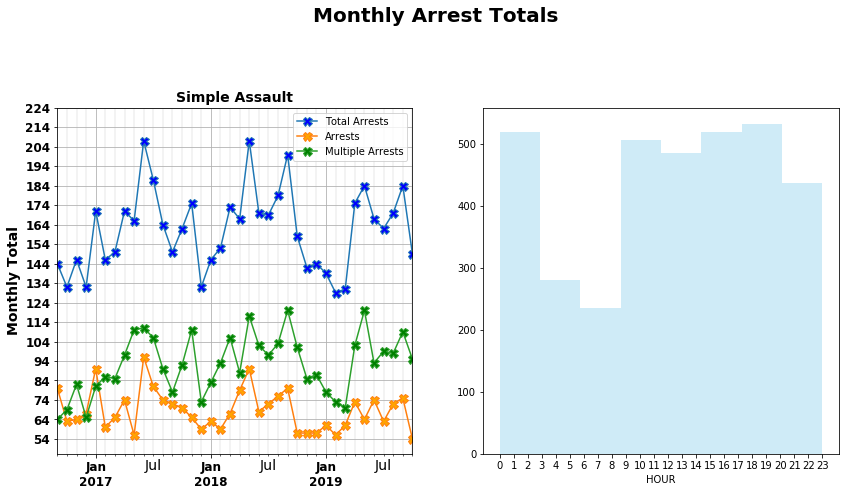

In [8]:
fig = plt.figure(figsize=(14,14))
sup_title=fig.suptitle('Monthly Arrest Totals',fontsize=20, fontweight='bold')

fontsize=14
ax=fig.add_subplot(2,2,1)

individ_month_arrests.plot(x='TIME',y='NUMOFFENSES',marker='X',markersize=9, markerfacecolor='blue',
                               ax=ax, label='Total Arrests',legend=False)
individ_month_arrests.plot(x='TIME',y='SINGLECHARGES',marker='X',markersize=9, markerfacecolor='orange',
                               ax=ax, label='Arrests',legend=False)
individ_month_arrests.plot(x='TIME',y='MULTIPLECHARGES',marker='X',markersize=9, markerfacecolor='green',
                               ax=ax, label='Multiple Arrests',legend=False)
ax.legend()

ax.set_title('Simple Assault',fontsize=fontsize,fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Monthly Total',fontsize=fontsize,fontweight='bold')
ax.set_yticks(np.arange(min(individ_month_arrests['SINGLECHARGES']), max(individ_month_arrests['NUMOFFENSES'])+20, 10))

for tick in ax.xaxis.get_ticklabels():
    tick.set(rotation=0)
    tick.set_fontweight('bold')
    tick.set_fontsize(12)
for tick in ax.yaxis.get_ticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(12)
    
ax.tick_params(axis='x', which='minor', labelsize=14)
ax.grid(b=True,which='major', linewidth=.8)
ax.grid(b=True,which='minor', linewidth=.3)
# end points brought to front
ax.axes.get_xaxis().set_visible(True)


ax=fig.add_subplot(2,2,2)
sns.distplot( individ_crime_multiple["HOUR"] , kde=False, color="skyblue", bins=8, label="Sepal Length",ax=ax)
ax.set_xticks(np.arange(0,24,1))
# individ_crime_multiple['AGE'].hist(ax=ax[0,1])

# individ_crime_multiple.dtypes


In [ ]:
individ_month_arrests['SINGLECHARGES'] =individ_crime_single_total.resample('M').agg(dict(NUMOFFENSES='count'))